In [1]:
## Import libaries
import pandas as pd
import numpy as np
import re
import itertools
from IPython.display import clear_output
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem import WordNetLemmatizer, PorterStemmer, LancasterStemmer
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import confusion_matrix, accuracy_score
pd.options.display.max_columns = None
pd.set_option('display.max_colwidth', -1)

In [2]:
lib_posts = pd.read_pickle('../data/liberal_posts_comms.pkl')
cons_posts = pd.read_pickle('../data/conservative_posts_comms.pkl')

In [3]:
lib_posts['target'], lib_posts['political_lean'] = 0, 'liberal'
cons_posts['target'], cons_posts['political_lean'] = 1, 'conservative'

In [4]:
df = pd.concat([lib_posts, cons_posts]).reset_index(drop=True)

In [5]:
baseline = max(df['target'].value_counts(normalize=True))
print(f'Baseline score: {round(baseline,4)}')

Baseline score: 0.5925


In [6]:
df.isna().sum().sum()

0

## Stemming & Lemming

In [7]:
def text_stem(text):
    tokenizer = RegexpTokenizer(r'[a-z]{3,}') ## 3 character minimum
    stemmer = PorterStemmer()
    text = re.sub(r'http\w:[\w\/\?.-]*','', text.lower()) # Removes URLs, sets text to lower-case
    tokens = tokenizer.tokenize(text)
    stemmed_tokes = [stemmer.stem(i) for i in tokens]
    stops = [stemmer.stem(sw) for sw in stopwords.words('english')]
    meaningful_tokens = [w for w in stemmed_tokes if not w in stops] ## Try without?!?
    return (' '.join(meaningful_tokens))

In [8]:
def text_lemma(text):
    tokenizer = RegexpTokenizer(r'[a-z]{3,}') 
    lemmatizer = WordNetLemmatizer()
    text = re.sub(r'http\w:[\w\/\?.-]*','', text.lower()) # Removes URLs, sets text to lower-case
    tokens = tokenizer.tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(i) for i in tokens]
    stops = [lemmatizer.lemmatize(sw) for sw in stopwords.words('english')]
    meaningful_tokens = [w for w in lemmatized_tokens if not w in stops]
    return (' '.join(meaningful_tokens))

In [9]:
df['text_stemmed'] = [text_stem(i) for i in df['text']]
df['title_stemmed'] = [text_stem(i) for i in df['title']]
df['comments_text_stemmed'] = [text_stem(i) for i in df['comments_text']]

df['text_lemma'] = [text_lemma(i) for i in df['text']]
df['title_lemma'] = [text_lemma(i) for i in df['title']]
df['comments_text_lemma'] = [text_lemma(i) for i in df['comments_text']]

In [10]:
empty_comments = df[(df['comments_text'] == '') | (df['comments_text'] == ' ')].shape[0]
df = df.drop(index=(df[df['comments_text_lemma'] == ''].index | df[df['comments_text_lemma'] == ' '].index))\
.reset_index(drop=True)
print(f'{empty_comments} rows removed\n{df.shape[0]} rows remain')

301 rows removed
1089 rows remain


## EDA

In [11]:
df['comments_char_count'] = df['comments_text'].map(len)
df['comments_word_count'] = df['comments_text'].map(lambda x: len(x.split()))
num_lib_comms = df['political_lean'].value_counts()['liberal']
num_cons_comms = df['political_lean'].value_counts()['conservative']

In [12]:
print(f'There are {num_lib_comms} posts from r/liberal')
print(f'There are {num_cons_comms} posts from r/conservative')

There are 445 posts from r/liberal
There are 644 posts from r/conservative


In [13]:
print(f"Mean comment character: {df['comments_char_count'].mean()}")
print(f"Mean comment words: {df['comments_word_count'].mean()}")

Mean comment character: 1636.842056932966
Mean comment words: 280.8971533516988


In [14]:
print(f"Mean Conservative comment words: {df[df['target'] == 1]['comments_word_count'].mean()}")
print(f"Mean Liberal comment words: {df[df['target'] == 0]['comments_word_count'].mean()}")

Mean Conservative comment words: 247.53416149068323
Mean Liberal comment words: 329.17977528089887


In [15]:
print(f"Mean Conservative comment characters: {df[df['target'] == 1]['comments_char_count'].mean()}")
print(f"Mean Liberal comment characters: {df[df['target'] == 0]['comments_char_count'].mean()}")

Mean Conservative comment characters: 1428.9114906832299
Mean Liberal comment characters: 1937.7573033707865


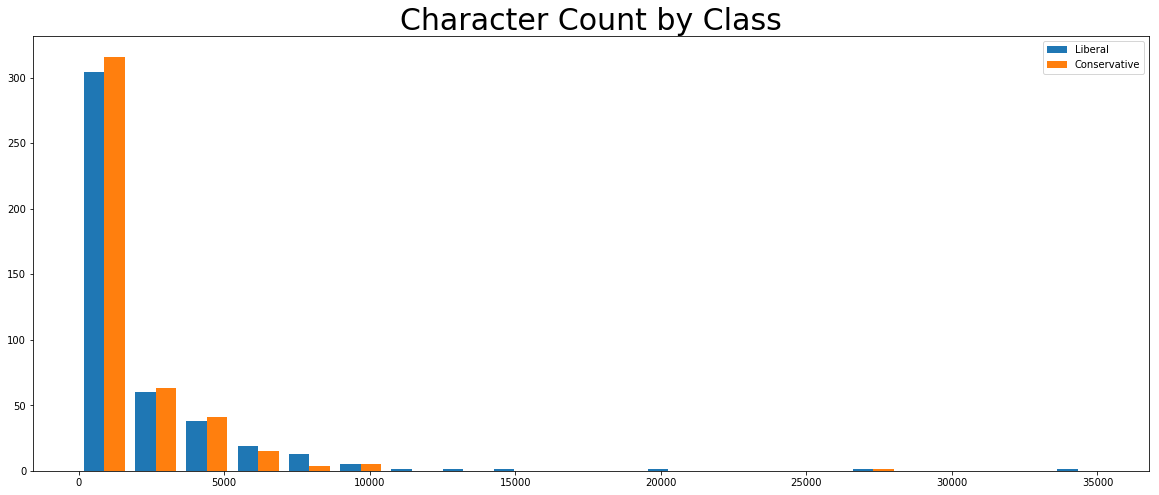

In [16]:
## Plots Character count for each class
plt.figure(figsize=(20,8))
plt.hist([df[df['target'] == 0]['comments_char_count'],
        random.sample(df[df['target'] == 1]['comments_char_count'].tolist(), ## Evens num of posts examined
                     num_lib_comms)],
        bins = 20);
plt.title('Character Count by Class', fontsize=30)
plt.legend(['Liberal', 'Conservative']);

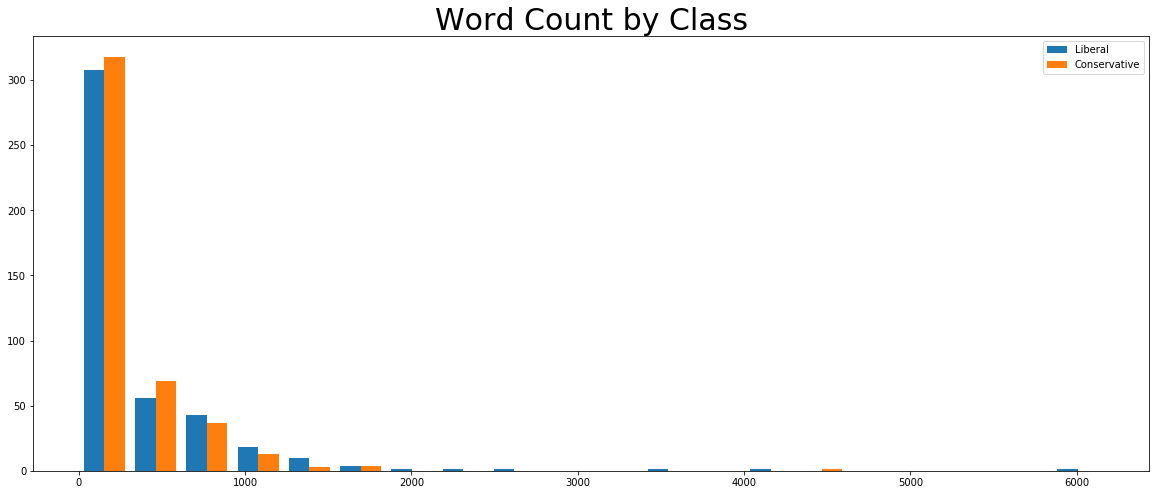

In [17]:
## Plots Word count for each class
plt.figure(figsize=(20,8))
plt.hist([df[df['target'] == 0]['comments_word_count'],
        random.sample(df[df['target'] == 1]['comments_word_count'].tolist(), ## Evens num of posts examined
                     num_lib_comms)],
        bins = 20);
plt.title('Word Count by Class', fontsize=30)
plt.legend(['Liberal', 'Conservative']);

In [18]:
cvec = CountVectorizer(min_df=4, max_df=1.0) # Instantiate CVEC
term_mat = cvec.fit_transform(df['comments_text_lemma']) 

In [19]:
term_df = pd.DataFrame(term_mat.toarray(), columns=cvec.get_feature_names()) # DF of cvec terms
term_df.insert(0, 'target_', df['target']) # Adding the target to DF
term_df.head()

target_  abiding  ability  able  abolish  aborted  abortion  absolute  \
0  0        0        0        0     0        0        0         0          
1  0        0        1        1     0        0        0         0          
2  0        0        0        0     0        0        0         0          
3  0        0        0        1     0        0        0         0          
4  0        0        0        0     0        0        0         0          

   absolutely  absurd  abuse  abused  abusing  abusive  aca  accept  \
0  0           0       0      0       0        0        0    0        
1  0           0       0      0       0        0        0    0        
2  0           0       1      0       0        0        0    0        
3  0           0       1      0       1        0        0    0        
4  0           0       0      0       0        0        0    0        

   acceptable  acceptance  accepted  accepting  accepts  access  accident  \
0  0           0           0         0          0        0       0          
1  0           0           0         0          0        0       0          
2  0           0           0         0          0        0       0          
3  0           0           0         0          0        0       0          
4  0           0           0         0          0        0       0          

   accidentally  accommodate  accomplish  accomplished  accomplishment  \
0  0             0            0           0             0                
1  0             0            0           0             0                
2  0             0            0           0             0                
3  0             0            0           0             0                
4  0             0            0           0             0                

   accord  according  accordingly  account  accountability  accountable  \
0  0       0          0            0        0               0             
1  0       0          0            0        0               0             
2  0       0          0            0        0               0             
3  0       0          0            1        0               0             
4  0       0          0            0        0               0             

   accounting  accurate  accurately  accusation  accuse  accused  accuser  \
0  0           0         0           0           0       0        0         
1  0           0         0           0           0       0        0         
2  0           0         0           0           0       0        0         
3  0           0         0           0           0       0        0         
4  0           0         0           0           0       0        0         

   accusing  achieve  achievement  acknowledge  across  act  acted  acting  \
0  0         0        0            0            0       0    0      0        
1  0         0        0            0            0       0    0      0        
2  0         0        0            0            0       0    0      0        
3  0         0        0            0            0       0    0      0        
4  0         0        0            0            0       0    0      0        

   action  active  actively  activism  activist  activity  actor  actual  \
0  0       0       0         0         0         0         0      0        
1  1       0       0         0         0         0         0      0        
2  0       0       0         0         0         0         0      0        
3  1       0       0         0         0         0         0      1        
4  0       0       0         0         0         0         0      0        

   actually  adam  add  added  adding  addition  additional  additionally  \
0  0         0     0    0      0       0         0           0              
1  0         0     0    0      0       0         0           0              
2  0         0     0    0      0       0         0           0              
3  1         0     0    0      0       0         0           0 

In [20]:
term_counts = {col : term_df[col].sum() for col in term_df.columns[1:]} # Dict of how often each term appears
tcd = pd.DataFrame(term_counts, index = ['counts']).T 

In [21]:
tcd.sort_values(by=['counts'], ascending=False).head(10) # Finding most frequent terms

,counts
people,1492
trump,1331
like,1228
would,1059
get,908
think,871
one,849
right,713
time,625
make,623


In [22]:
top200 = list(tcd.sort_values(by='counts', ascending=False).head(200).index) # Stores 200 most common terms
top200.append('target_') # Adds target (underscore to differentiate from 'target', one of the terms)

In [23]:
bottom20corrs = list(term_df[top200].corr()['target_'].sort_values().index[:20]) # 20 least corr with target_
bottom20corrs.append('target_')
## 20 most corr with target_
top20corrs = list(term_df[top200].corr()['target_'].sort_values(ascending=False).index[:21])

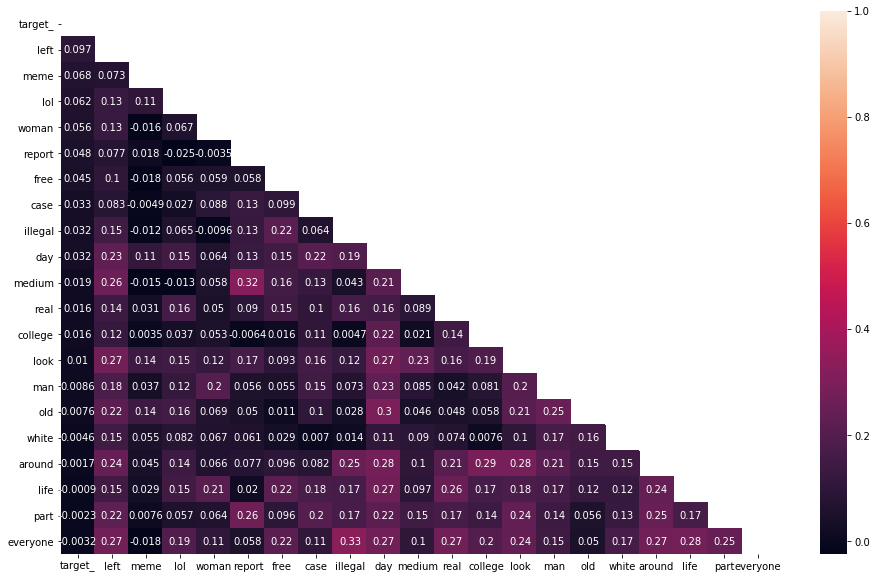

In [24]:
## View of the most correlated terms to target_
plt.figure(figsize = (16,10))

corr = term_df[top20corrs].corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr,mask = mask, annot=True);

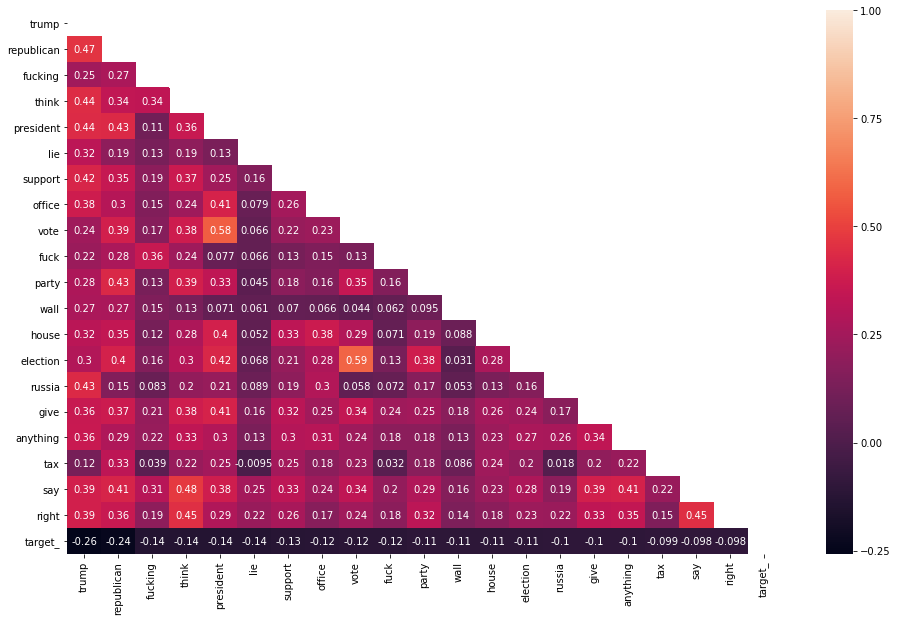

In [25]:
## View of terms least correlated to target
plt.figure(figsize = (16,10))

corr = term_df[bottom20corrs].corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr,mask = mask, annot=True);

## Model Exploration

Summary: The highest performing models, before any Grid Search, were
- Logistic Regression Standard TfidfVectorizer Model: 0.70 CV Score
- Naive Bayes Count Vectorized Model: 0.71 CV Score
- Gradient Boosting Classifier Standard TfidfVectorizer Model: 0.71 CV Score

And for LSA models:
- Logistic Regression Standard TfidfVectorizer Model: 0.72 CV Score

In [26]:
## Sets TfidfVectorizer of X, y, performs train/test split, returns X, y and train/test of each
def tvec_set_inputs(df, features, target):
    X_train, X_test, y_train, y_test = train_test_split(df[[features]],
                                                   df[target],
                                                   test_size = .25,
                                                   random_state = 42)
    tvec = TfidfVectorizer()
    tvec.fit_transform(X_train[features])
    
    X_train_tvec = pd.DataFrame(tvec.fit_transform(X_train[features]).todense(),
                            columns = tvec.get_feature_names())
    
    X_test_tvec = pd.DataFrame(tvec.transform(X_test[features]).todense(),
                            columns = tvec.get_feature_names())
    
    X_tvec = pd.DataFrame(tvec.transform(df[features]).todense(), columns = tvec.get_feature_names())
    y = df[target]
    
    return X_tvec, X_train_tvec, X_test_tvec, y, y_train, y_test

In [27]:
## Sets CountVectorizer of X, y, performs train/test split, returns X, y and train/test of each
def cvec_set_inputs(df, features, target):
    X_train, X_test, y_train, y_test = train_test_split(df[[features]],
                                                   df[target],
                                                   test_size = .25,
                                                   random_state = 42)
    cvec = CountVectorizer(min_df=1, max_df=1.0)
    cvec.fit_transform(X_train[features])
    
    X_train_cvec = pd.DataFrame(cvec.fit_transform(X_train[features]).todense(),
                            columns = cvec.get_feature_names())
    
    X_test_cvec = pd.DataFrame(cvec.transform(X_test[features]).todense(),
                            columns = cvec.get_feature_names())
    
    X_cvec = pd.DataFrame(cvec.transform(df[features]).todense(), columns = cvec.get_feature_names())
    
    y = df[target]
    
    return X_cvec, X_train_cvec, X_test_cvec, y, y_train, y_test

In [28]:
## Takes the input vector notation and chooses the right vectorizer
def sort_vector(df, features, target, vector_type):
    if vector_type == 'cvec':
        X, X_train, X_test, y, y_train, y_test = cvec_set_inputs(df, features, target)
    elif vector_type == 'tvec':
        X, X_train, X_test, y, y_train, y_test = tvec_set_inputs(df, features, target)
    else:
        print('Unacceptable vector_type')  
    return X, X_train, X_test, y, y_train, y_test
    

In [29]:
## Runs the standard model (not bag or ada) and provides clean ouput statements
def standard_model_run(df, features, target, vector_type, model):
    X_vec, X_train_vec, X_test_vec, y, y_train, y_test = sort_vector(df, features, target, vector_type)

    print(f'|------------------------\n|Standard Model\n|Baseline: {round(baseline,4)}\n'\
          +'|------------------------')
    instantiated_model = model
    fit_model = instantiated_model.fit(X_train_vec, y_train)
    predictions = model.predict(X_test_vec)  
    print('|Train score:',round(fit_model.score(X_train_vec, y_train), 4))
    print('|Test score:',round(fit_model.score(X_test_vec, y_test), 4))
    print('|Cross Val Score:',round(cross_val_score(fit_model,X_vec,df[target],cv=5).mean(), 4))
    cm = confusion_matrix(y_test, predictions)
    cm_df = pd.DataFrame(cm, columns=['Pred Neg (Lib)', 'Pred Pos (Cons)'],
                     index=['Actual Neg (Lib)', 'Actual Pos (Cons)'])
    print(f'\n{cm_df}\n')

In [30]:
## Runs the model through Bagging and provides clean ouput statements
def bag_model_run(df, features, target, vector_type, model):
    X_vec, X_train_vec, X_test_vec, y, y_train, y_test = sort_vector(df, features, target, vector_type)  

    print(f'|------------------------\n|Bagged Model\n|Baseline: {round(baseline,4)}\n'\
          +'|------------------------')
    bag = BaggingClassifier(base_estimator=model)
    bag.fit(X_train_vec, y_train)
    predictions = bag.predict(X_test_vec)   
    print('|Training score: ', round(bag.score(X_train_vec, y_train), 4))
    print('|Test score: ', round(bag.score(X_test_vec, y_test), 4))
    print('|Cross Val Score:',round(cross_val_score(bag,X_vec,df[target],cv=5).mean(), 4))
    cm = confusion_matrix(y_test, predictions)
    cm_df = pd.DataFrame(cm, columns=['Pred Neg (Lib)', 'Pred Pos (Cons)'],
                     index=['Actual Neg (Lib)', 'Actual Pos (Cons)'])
    print(f'\n{cm_df}\n')

In [31]:
## Runs the model through AdaBooster and provides clean ouput statements
def ada_model_run(df, features, target, vector_type, model):
    ## Calls the sort_vector function to run the right vector and return X, y, train-test split values
    X_vec, X_train_vec, X_test_vec, y, y_train, y_test = sort_vector(df, features, target, vector_type)

    print(f'|------------------------\n|AdaBoost Model\n|Baseline: {round(baseline,4)}\n'\
          +'|------------------------')
    ada = AdaBoostClassifier(base_estimator=model)
    ada.fit(X_train_vec, y_train)
    predictions = ada.predict(X_test_vec)
    print('|Training score: ', round(ada.score(X_train_vec, y_train), 4))
    print('|Test score: ', round(ada.score(X_test_vec, y_test), 4))
    print('|Cross Val Score:', round(cross_val_score(ada,X_vec,df[target],cv=5).mean(), 4))
    cm = confusion_matrix(y_test, predictions)
    cm_df = pd.DataFrame(cm, columns=['Pred Neg (Lib)', 'Pred Pos (Cons)'],
                     index=['Actual Neg (Lib)', 'Actual Pos (Cons)'])
    print(f'\n{cm_df}\n')
    

### Logistic Regression

Results: Standard TfidfVectorizer Model perfomed strongest with a Cross Val Score of 0.70 and a lean toward Positive predictions.

In [32]:
standard_model_run(df, 'comments_text_lemma', 'target', 'cvec', LogisticRegression(solver='liblinear'))
standard_model_run(df, 'comments_text_lemma', 'target', 'tvec', LogisticRegression(solver='liblinear'))

|------------------------
|Standard Model
|Baseline: 0.5925
|------------------------
|Train score: 0.9926
|Test score: 0.685
|Cross Val Score: 0.6786

                   Pred Neg (Lib)  Pred Pos (Cons)
Actual Neg (Lib)   62              55             
Actual Pos (Cons)  31              125            

|------------------------
|Standard Model
|Baseline: 0.5925
|------------------------
|Train score: 0.8775
|Test score: 0.663
|Cross Val Score: 0.7025

                   Pred Neg (Lib)  Pred Pos (Cons)
Actual Neg (Lib)   33              84             
Actual Pos (Cons)  8               148            



In [33]:
bag_model_run(df, 'comments_text_lemma', 'target', 'cvec', LogisticRegression(solver='liblinear'))
bag_model_run(df, 'comments_text_lemma', 'target', 'tvec', LogisticRegression(solver='liblinear'))

|------------------------
|Bagged Model
|Baseline: 0.5925
|------------------------
|Training score:  0.9694
|Test score:  0.6777
|Cross Val Score: 0.6777

                   Pred Neg (Lib)  Pred Pos (Cons)
Actual Neg (Lib)   56              61             
Actual Pos (Cons)  27              129            

|------------------------
|Bagged Model
|Baseline: 0.5925
|------------------------
|Training score:  0.8321
|Test score:  0.652
|Cross Val Score: 0.6951

                   Pred Neg (Lib)  Pred Pos (Cons)
Actual Neg (Lib)   28              89             
Actual Pos (Cons)  6               150            



In [34]:
ada_model_run(df, 'comments_text_lemma', 'target', 'cvec', LogisticRegression(solver='liblinear'))
ada_model_run(df, 'comments_text_lemma', 'target', 'tvec', LogisticRegression(solver='liblinear'))

|------------------------
|AdaBoost Model
|Baseline: 0.5925
|------------------------
|Training score:  0.9424
|Test score:  0.696
|Cross Val Score: 0.6942

                   Pred Neg (Lib)  Pred Pos (Cons)
Actual Neg (Lib)   54              63             
Actual Pos (Cons)  20              136            

|------------------------
|AdaBoost Model
|Baseline: 0.5925
|------------------------
|Training score:  0.598
|Test score:  0.5714
|Cross Val Score: 0.5914

                   Pred Neg (Lib)  Pred Pos (Cons)
Actual Neg (Lib)   0               117            
Actual Pos (Cons)  0               156            



### Naive Bayes
Results: The Bagged Model using a Count Vectorizer had the strongest Crosss Val Score at 0.71 – there were exactly 40 False Positive and 40 False Negatives. The Standard Count Vectorizer Model performed second best with a Cross Val Score of 0.71 (0.002 lower) and was fairly even, maybe slightly Negative-leaning, spread of Positive & Negative predictions.

Notes: The TF-IFD way over-predicted Positive. It may be worth re-testing with adjustments.

In [35]:
standard_model_run(df, 'comments_text_lemma', 'target', 'cvec', MultinomialNB())
standard_model_run(df, 'comments_text_lemma', 'target', 'tvec', MultinomialNB())

|------------------------
|Standard Model
|Baseline: 0.5925
|------------------------
|Train score: 0.951
|Test score: 0.6593
|Cross Val Score: 0.7062

                   Pred Neg (Lib)  Pred Pos (Cons)
Actual Neg (Lib)   73              44             
Actual Pos (Cons)  49              107            

|------------------------
|Standard Model
|Baseline: 0.5925
|------------------------
|Train score: 0.8897
|Test score: 0.5934
|Cross Val Score: 0.6336

                   Pred Neg (Lib)  Pred Pos (Cons)
Actual Neg (Lib)   11              106            
Actual Pos (Cons)  5               151            



In [36]:
bag_model_run(df, 'comments_text_lemma', 'target', 'cvec', MultinomialNB())
bag_model_run(df, 'comments_text_lemma', 'target', 'tvec', MultinomialNB())

|------------------------
|Bagged Model
|Baseline: 0.5925
|------------------------
|Training score:  0.9314
|Test score:  0.6813
|Cross Val Score: 0.708

                   Pred Neg (Lib)  Pred Pos (Cons)
Actual Neg (Lib)   73              44             
Actual Pos (Cons)  43              113            

|------------------------
|Bagged Model
|Baseline: 0.5925
|------------------------
|Training score:  0.8676
|Test score:  0.5934
|Cross Val Score: 0.6318

                   Pred Neg (Lib)  Pred Pos (Cons)
Actual Neg (Lib)   11              106            
Actual Pos (Cons)  5               151            



In [37]:
ada_model_run(df, 'comments_text_lemma', 'target', 'cvec', MultinomialNB())
ada_model_run(df, 'comments_text_lemma', 'target', 'tvec', MultinomialNB())

|------------------------
|AdaBoost Model
|Baseline: 0.5925
|------------------------
|Training score:  0.5306
|Test score:  0.5018
|Cross Val Score: 0.5106

                   Pred Neg (Lib)  Pred Pos (Cons)
Actual Neg (Lib)   45              72             
Actual Pos (Cons)  64              92             

|------------------------
|AdaBoost Model
|Baseline: 0.5925
|------------------------
|Training score:  0.6189
|Test score:  0.5751
|Cross Val Score: 0.5969

                   Pred Neg (Lib)  Pred Pos (Cons)
Actual Neg (Lib)   1               116            
Actual Pos (Cons)  0               156            



### Random Trees

Results: Bagged TfidfVectorizer Model performed best with a Cross Val Score of 0.69 with a slightly Negative-leaning spread of Negative & Positive predictions.

In [38]:
## Running functions to test models
standard_model_run(df, 'comments_text_lemma', 'target', 'cvec', DecisionTreeClassifier())
standard_model_run(df, 'comments_text_lemma', 'target', 'tvec', DecisionTreeClassifier())

|------------------------
|Standard Model
|Baseline: 0.5925
|------------------------
|Train score: 1.0
|Test score: 0.6117
|Cross Val Score: 0.6134

                   Pred Neg (Lib)  Pred Pos (Cons)
Actual Neg (Lib)   54              63             
Actual Pos (Cons)  43              113            

|------------------------
|Standard Model
|Baseline: 0.5925
|------------------------
|Train score: 1.0
|Test score: 0.6667
|Cross Val Score: 0.6253

                   Pred Neg (Lib)  Pred Pos (Cons)
Actual Neg (Lib)   64              53             
Actual Pos (Cons)  38              118            



In [39]:
bag_model_run(df, 'comments_text_lemma', 'target', 'cvec', DecisionTreeClassifier())
bag_model_run(df, 'comments_text_lemma', 'target', 'tvec', DecisionTreeClassifier())

|------------------------
|Bagged Model
|Baseline: 0.5925
|------------------------
|Training score:  0.9828
|Test score:  0.6374
|Cross Val Score: 0.651

                   Pred Neg (Lib)  Pred Pos (Cons)
Actual Neg (Lib)   61              56             
Actual Pos (Cons)  43              113            

|------------------------
|Bagged Model
|Baseline: 0.5925
|------------------------
|Training score:  0.9841
|Test score:  0.63
|Cross Val Score: 0.6877

                   Pred Neg (Lib)  Pred Pos (Cons)
Actual Neg (Lib)   57              60             
Actual Pos (Cons)  41              115            



In [40]:
ada_model_run(df, 'comments_text_lemma', 'target', 'cvec', DecisionTreeClassifier())
ada_model_run(df, 'comments_text_lemma', 'target', 'tvec', DecisionTreeClassifier())

|------------------------
|AdaBoost Model
|Baseline: 0.5925
|------------------------
|Training score:  1.0
|Test score:  0.6044
|Cross Val Score: 0.629

                   Pred Neg (Lib)  Pred Pos (Cons)
Actual Neg (Lib)   51              66             
Actual Pos (Cons)  42              114            

|------------------------
|AdaBoost Model
|Baseline: 0.5925
|------------------------
|Training score:  1.0
|Test score:  0.6484
|Cross Val Score: 0.6208

                   Pred Neg (Lib)  Pred Pos (Cons)
Actual Neg (Lib)   60              57             
Actual Pos (Cons)  39              117            



### KNN

Results: Cross Val Score was highest for Standard TfidfVectorizer Model (0.67).

Notes: Cross Val Scores didn't look great for the Standard Count Vectorizer Model (0.62), Bagged Count Vectorizer Model (0.62) the Standard TfidfVectorizer Model (0.63), or the Bagged TfidfVectorizer Model (0.63). It *may* be worth trying a GridSearchCV on the Standard TfidfVectorizer Model later but unlikely to yield much.

In [41]:
standard_model_run(df, 'comments_text_lemma', 'target', 'cvec', KNeighborsClassifier())
standard_model_run(df, 'comments_text_lemma', 'target', 'tvec', KNeighborsClassifier())

|------------------------
|Standard Model
|Baseline: 0.5925
|------------------------
|Train score: 0.7451
|Test score: 0.6044
|Cross Val Score: 0.6409

                   Pred Neg (Lib)  Pred Pos (Cons)
Actual Neg (Lib)   88              29             
Actual Pos (Cons)  79              77             

|------------------------
|Standard Model
|Baseline: 0.5925
|------------------------
|Train score: 0.8015
|Test score: 0.6813
|Cross Val Score: 0.6731

                   Pred Neg (Lib)  Pred Pos (Cons)
Actual Neg (Lib)   82              35             
Actual Pos (Cons)  52              104            



In [42]:
bag_model_run(df, 'comments_text_lemma', 'target', 'cvec', KNeighborsClassifier())
bag_model_run(df, 'comments_text_lemma', 'target', 'tvec', KNeighborsClassifier())

|------------------------
|Bagged Model
|Baseline: 0.5925
|------------------------
|Training score:  0.7316
|Test score:  0.5495
|Cross Val Score: 0.6116

                   Pred Neg (Lib)  Pred Pos (Cons)
Actual Neg (Lib)   82              35             
Actual Pos (Cons)  88              68             

|------------------------
|Bagged Model
|Baseline: 0.5925
|------------------------
|Training score:  0.8088
|Test score:  0.674
|Cross Val Score: 0.6685

                   Pred Neg (Lib)  Pred Pos (Cons)
Actual Neg (Lib)   81              36             
Actual Pos (Cons)  53              103            



In [43]:
## AdaBooster crashed with KNN

### GradientBoostingClassifier
Results: The Standard TfidfVectorizer Model had a Cross Val Score of 0.70, with predictions that leaned fairly Positive.

In [44]:
standard_model_run(df, 'comments_text_lemma', 'target', 'cvec', GradientBoostingClassifier())
standard_model_run(df, 'comments_text_lemma', 'target', 'tvec', GradientBoostingClassifier())

|------------------------
|Standard Model
|Baseline: 0.5925
|------------------------
|Train score: 0.8505
|Test score: 0.7033
|Cross Val Score: 0.7043

                   Pred Neg (Lib)  Pred Pos (Cons)
Actual Neg (Lib)   51              66             
Actual Pos (Cons)  15              141            

|------------------------
|Standard Model
|Baseline: 0.5925
|------------------------
|Train score: 0.9118
|Test score: 0.674
|Cross Val Score: 0.697

                   Pred Neg (Lib)  Pred Pos (Cons)
Actual Neg (Lib)   54              63             
Actual Pos (Cons)  26              130            



### Support Vector Machine

Results: Results were pretty weak with the Bagged Count Vectorizer Model having the highest Cross Val Score of 0.61.

In [45]:
standard_model_run(df, 'comments_text_lemma', 'target', 'cvec', svm.SVC(gamma='auto'))
standard_model_run(df, 'comments_text_lemma', 'target', 'tvec', svm.SVC(gamma='auto'))

|------------------------
|Standard Model
|Baseline: 0.5925
|------------------------
|Train score: 0.6324
|Test score: 0.5714
|Cross Val Score: 0.6033

                   Pred Neg (Lib)  Pred Pos (Cons)
Actual Neg (Lib)   2               115            
Actual Pos (Cons)  2               154            

|------------------------
|Standard Model
|Baseline: 0.5925
|------------------------
|Train score: 0.598
|Test score: 0.5714
|Cross Val Score: 0.5914

                   Pred Neg (Lib)  Pred Pos (Cons)
Actual Neg (Lib)   0               117            
Actual Pos (Cons)  0               156            



In [46]:
bag_model_run(df, 'comments_text_lemma', 'target', 'cvec', svm.SVC(gamma='auto'))
bag_model_run(df, 'comments_text_lemma', 'target', 'tvec', svm.SVC(gamma='auto'))

|------------------------
|Bagged Model
|Baseline: 0.5925
|------------------------
|Training score:  0.6422
|Test score:  0.5751
|Cross Val Score: 0.6088

                   Pred Neg (Lib)  Pred Pos (Cons)
Actual Neg (Lib)   3               114            
Actual Pos (Cons)  2               154            

|------------------------
|Bagged Model
|Baseline: 0.5925
|------------------------
|Training score:  0.598
|Test score:  0.5714
|Cross Val Score: 0.5914

                   Pred Neg (Lib)  Pred Pos (Cons)
Actual Neg (Lib)   0               117            
Actual Pos (Cons)  0               156            



## Latent Semantic Analysis

In [47]:
## Function to apply a TfidfVectorizer to the X and Y data and return an svd dataframe for LSA analysis
def tvec_lsa(feature, target):
    tvec = TfidfVectorizer(stop_words='english', min_df=5, max_df=1.0)

    term_mat = tvec.fit_transform(df[feature])
    term_df = pd.DataFrame(term_mat.toarray(), columns=tvec.get_feature_names())

    ## Instantiates truncated SVD (aka LSA) to reduce dimensions into interactions
    SVD = TruncatedSVD(n_components=100)
    svd_matrix = SVD.fit_transform(term_df) ## fits SVD to a matrix

    component_names = ["component_"+str(i+1) for i in range(100)] ##Adds columns names (may not need)
    svd_df = pd.DataFrame(svd_matrix,
                          columns=component_names)
    ## Train test split dataframe
    X_train, X_test, y_train, y_test = train_test_split(svd_df,
                                                        df[target],
                                                        stratify=df['target'],
                                                        random_state=42)

    X = svd_df
    y = df['target']
    
    return X, X_train, X_test, y, y_train, y_test

In [48]:
## Function to apply a CountVectorizer to the X and Y data and return an svd dataframe for LSA analysis
def cvec_lsa(feature, target):
    cvec = CountVectorizer(stop_words='english', min_df=5, max_df=1.0)

    term_mat = cvec.fit_transform(df[feature])
    term_df = pd.DataFrame(term_mat.toarray(), columns=cvec.get_feature_names())

    ## Instantiates truncated SVD (aka LSA) to reduce dimensions into interactions
    SVD = TruncatedSVD(n_components=100) 
    svd_matrix = SVD.fit_transform(term_df) ## fits SVD to a matrix

    component_names = ["component_"+str(i+1) for i in range(100)] ##Adds columns names (may not need)
    svd_df = pd.DataFrame(svd_matrix, ## Converts to DataFrame
                          columns=component_names)
    ## Train test split dataframe
    X_train, X_test, y_train, y_test = train_test_split(svd_df, 
                                                        df[target],
                                                        stratify=df['target'],
                                                        random_state=42)

    X = svd_df
    y = df['target']
    
    return X, X_train, X_test, y, y_train, y_test

### Logisitic Regression (LSA)

In [49]:
## Performs Logistic Regression on LSA using CVEC
X, X_train, X_test, y, y_train, y_test = cvec_lsa(feature='comments_text_lemma',
                                                  target='target')

logreg = LogisticRegression(solver='liblinear')
logreg.fit(X_train, y_train)
predictions = logreg.predict(X_test)
print('|Training score: ', round(logreg.score(X_train, y_train), 4))
print('|Test score: ', round(logreg.score(X_test, y_test), 4))
print('|Cross Val Score:', round(cross_val_score(logreg, X, df['target'], cv=5).mean(), 4))
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(cm, columns=['Pred Neg (Lib)', 'Pred Pos (Cons)'],
             index=['Actual Neg (Lib)', 'Actual Pos (Cons)'])
print(f'\n{cm_df}\n')

|Training score:  0.7647
|Test score:  0.6923
|Cross Val Score: 0.6832

                   Pred Neg (Lib)  Pred Pos (Cons)
Actual Neg (Lib)   61              51             
Actual Pos (Cons)  33              128            



In [50]:
## Performs Logistic Regression on LSA using TVEC
X, X_train, X_test, y, y_train, y_test = tvec_lsa(feature='comments_text_lemma',
                                                  target='target')

logreg = LogisticRegression(solver='liblinear')
logreg.fit(X_train, y_train)
predictions = logreg.predict(X_test)
print('|Training score: ', round(logreg.score(X_train, y_train), 4))
print('|Test score: ', round(logreg.score(X_test, y_test), 4))
print('|Cross Val Score:', round(cross_val_score(logreg, X, df['target'], cv=5).mean(), 4))
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(cm, columns=['Pred Neg (Lib)', 'Pred Pos (Cons)'],
             index=['Actual Neg (Lib)', 'Actual Pos (Cons)'])
print(f'\n{cm_df}\n')

|Training score:  0.7451
|Test score:  0.7582
|Cross Val Score: 0.7236

                   Pred Neg (Lib)  Pred Pos (Cons)
Actual Neg (Lib)   59              53             
Actual Pos (Cons)  13              148            



### Naive Bayes (LSA)

In [51]:
# X, X_train, X_test, y, y_train, y_test = cvec_lsa(feature='comments_text_lemma',
#                                                   target='target')
# print(X_train.shape)
# nb = MultinomialNB()
# nb.fit(X_train, y_train)
# predictions = nb.predict(X_test)
# print('|Training score: ', round(nb.score(X_train, y_train), 4))
# print('|Test score: ', round(nb.score(X_test, y_test), 4))
# print('|Cross Val Score:', round(cross_val_score(nb, X, df['target'], cv=5).mean(), 4))
# cm = confusion_matrix(y_test, predictions)
# cm_df = pd.DataFrame(cm, columns=['Pred Neg (Lib)', 'Pred Pos (Cons)'],
#              index=['Actual Neg (Lib)', 'Actual Pos (Cons)'])
# print(f'\n{cm_df}\n')

### Random Trees (LSA)

In [52]:
## Performs Decision Tree Classifier on LSA using TVEC
X, X_train, X_test, y, y_train, y_test = tvec_lsa(feature='comments_text_lemma',
                                                  target='target')
print(X_train.shape)
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
predictions = dt.predict(X_test)
print('|Training score: ', round(dt.score(X_train, y_train), 4))
print('|Test score: ', round(dt.score(X_test, y_test), 4))
print('|Cross Val Score:', round(cross_val_score(dt, X, df['target'], cv=5).mean(), 4))
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(cm, columns=['Pred Neg (Lib)', 'Pred Pos (Cons)'],
             index=['Actual Neg (Lib)', 'Actual Pos (Cons)'])
print(f'\n{cm_df}\n')

(816, 100)
|Training score:  1.0
|Test score:  0.6264
|Cross Val Score: 0.5978

                   Pred Neg (Lib)  Pred Pos (Cons)
Actual Neg (Lib)   57              55             
Actual Pos (Cons)  47              114            



### KNN (LSA)

In [53]:
## Performs KNN on LSA using TVEC
X, X_train, X_test, y, y_train, y_test = tvec_lsa(feature='comments_text_lemma',
                                                  target='target')
print(X_train.shape)
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
predictions = knn.predict(X_test)
print('|Training score: ', round(knn.score(X_train, y_train), 4))
print('|Test score: ', round(knn.score(X_test, y_test), 4))
print('|Cross Val Score:', round(cross_val_score(knn, X, df['target'], cv=5).mean(), 4))
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(cm, columns=['Pred Neg (Lib)', 'Pred Pos (Cons)'],
             index=['Actual Neg (Lib)', 'Actual Pos (Cons)'])
print(f'\n{cm_df}\n')

(816, 100)
|Training score:  0.7659
|Test score:  0.7106
|Cross Val Score: 0.6438

                   Pred Neg (Lib)  Pred Pos (Cons)
Actual Neg (Lib)   46              66             
Actual Pos (Cons)  13              148            



### GradientBoosting (LSA)

In [54]:
## Performs Gradient Booster on LSA using CVEC
X, X_train, X_test, y, y_train, y_test = cvec_lsa(feature='comments_text_lemma',
                                                  target='target')
print(X_train.shape)
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
predictions = gb.predict(X_test)
print('|Training score: ', round(gb.score(X_train, y_train), 4))
print('|Test score: ', round(gb.score(X_test, y_test), 4))
print('|Cross Val Score:', round(cross_val_score(gb, X, df['target'], cv=5).mean(), 4))
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(cm, columns=['Pred Neg (Lib)', 'Pred Pos (Cons)'],
             index=['Actual Neg (Lib)', 'Actual Pos (Cons)'])
print(f'\n{cm_df}\n')

(816, 100)
|Training score:  0.9939
|Test score:  0.6886
|Cross Val Score: 0.6612

                   Pred Neg (Lib)  Pred Pos (Cons)
Actual Neg (Lib)   58              54             
Actual Pos (Cons)  31              130            



### Support Vector Machine (LSA)

In [55]:
## Performs SVM on LSA using CVEC
X, X_train, X_test, y, y_train, y_test = cvec_lsa(feature='comments_text_lemma',
                                                  target='target')
print(X_train.shape)
svc = svm.SVC(gamma='auto')
svc.fit(X_train, y_train)
predictions = svc.predict(X_test)
print('|Training score: ', round(svc.score(X_train, y_train), 4))
print('|Test score: ', round(svc.score(X_test, y_test), 4))
print('|Cross Val Score:', round(cross_val_score(svc, X, df['target'], cv=5).mean(), 4))
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(cm, columns=['Pred Neg (Lib)', 'Pred Pos (Cons)'],
             index=['Actual Neg (Lib)', 'Actual Pos (Cons)'])
print(f'\n{cm_df}\n')

(816, 100)
|Training score:  0.7574
|Test score:  0.6813
|Cross Val Score: 0.6621

                   Pred Neg (Lib)  Pred Pos (Cons)
Actual Neg (Lib)   33              79             
Actual Pos (Cons)  8               153            



In [56]:
## Export new dataframe to a pkl file
pd.to_pickle(df, path='../data/df_comments.pkl')